In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib
import re

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

import os
from os import listdir

from numpy.linalg import svd, pinv
from scipy.linalg import eig

In [2]:
Lx, Ly, Lz = 12,12,1
Nx, Ny, Nz = 384, 384, 32

Ra_M = 1.0e6

Prandtl = 1.0

D_0 = 0
D_H = [i/24 for i in range(-4, 9)]
M_0 = 0
M_H = -1

print(D_H)

N_s2 = [dh - M_H + 0.001 for dh in D_H]

Ra_D = [Ra_M * (D_0-dh) / (M_0-M_H) for dh in D_H]

dealias = 3/2
stop_sim_time = 2000
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

nu = [(Ra_M / (Prandtl*(M_0-M_H)*Lz**3))**(-1/2) for ind in range(len(D_H))]

print(type(nu))
print(nu)
nu = 0.001

[-0.16666666666666666, -0.125, -0.08333333333333333, -0.041666666666666664, 0.0, 0.041666666666666664, 0.08333333333333333, 0.125, 0.16666666666666666, 0.20833333333333334, 0.25, 0.2916666666666667, 0.3333333333333333]
<class 'list'>
[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


In [3]:
all_filepaths = []
names = ["n4", 'n3', 'n2', 'n1','00', 'p1','p2','p3','p4','p5','p6','p7','p8']
DHs = [-4,-3,-2,-1, 0, 1,2,3,4,5,6,7,8]
for name in names:
    folder_dir = f"analysis_{name}o24"

    file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
    #sort by the number in the file name
    file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
    print(file_paths)
    all_filepaths.append(file_paths)
print(all_filepaths)

['analysis_n4o24/analysis_n4o24_s1.h5', 'analysis_n4o24/analysis_n4o24_s2.h5']
['analysis_n3o24/analysis_n3o24_s1.h5', 'analysis_n3o24/analysis_n3o24_s2.h5']
['analysis_n2o24/analysis_n2o24_s1.h5', 'analysis_n2o24/analysis_n2o24_s2.h5']
['analysis_n1o24/analysis_n1o24_s1.h5', 'analysis_n1o24/analysis_n1o24_s2.h5']
['analysis_00o24/analysis_00o24_s1.h5', 'analysis_00o24/analysis_00o24_s2.h5']
['analysis_p1o24/analysis_p1o24_s1.h5', 'analysis_p1o24/analysis_p1o24_s2.h5']
['analysis_p2o24/analysis_p2o24_s1.h5', 'analysis_p2o24/analysis_p2o24_s2.h5']
['analysis_p3o24/analysis_p3o24_s1.h5', 'analysis_p3o24/analysis_p3o24_s2.h5']
['analysis_p4o24/analysis_p4o24_s1.h5', 'analysis_p4o24/analysis_p4o24_s2.h5']
['analysis_p5o24/analysis_p5o24_s1.h5', 'analysis_p5o24/analysis_p5o24_s2.h5']
['analysis_p6o24/analysis_p6o24_s1.h5', 'analysis_p6o24/analysis_p6o24_s2.h5']
['analysis_p7o24/analysis_p7o24_s1.h5', 'analysis_p7o24/analysis_p7o24_s2.h5']
['analysis_p8o24/analysis_p8o24_s1.h5', 'analysis_p8

In [4]:
def get_all_data(task, Nz, path):
    recorded = False
    for file in path:
        with h5py.File(file, mode='r') as file:
            st = file['scales/sim_time']
            simtime = np.array(st)
            avg_0 = file["tasks"][task]
            avg = np.reshape(avg_0, (len(simtime),Nz))
            for t in range(len(simtime)):
                avg_T=np.transpose(avg[t,:])
                avg_T = np.reshape(avg_T, (1, Nz))
                if recorded == False:
                    avg_all_time = avg_T
                    recorded = True
                else:
                    avg_all_time = np.concatenate((avg_all_time, avg_T))
    #print(np.shape(avg_all_time))
    #print(np.shape(np.transpose(avg_all_time[:,:])))
    avg_allt_T=np.transpose(avg_all_time[:,:])
    return avg_allt_T
def draw_contour(avg_allt_T, task):
    max_lev, min_lev = np.max(avg_allt_T), np.min(avg_allt_T)
    levels = np.arange(min_lev-(max_lev-min_lev)/32, max_lev+(max_lev-min_lev)/32, (max_lev-min_lev)/32)
    #plt.contourf(avg_allt_T, levels, cmap='Spectral_r')
    plt.contourf(avg_allt_T, levels, cmap='rainbow')
    plt.colorbar(label=f'{task}')
    plt.xlabel('time')
    plt.ylabel('z')
    plt.title(f'{task} vs time')
    #plt.savefig(f'{task.replace(" ", "_")}.png', dpi=200,bbox_inches='tight')
    plt.show()
    matplotlib.pyplot.close()

In [5]:

def DMD(mat_A, r=None):
    """
    Perform Dynamic Mode Decomposition (DMD) on the dataset KE_all_time.

    Parameters:
    - KE_all_time: NumPy array of shape (32, 2000), where each column is a data snapshot.
    - r: Number of singular values/modes to keep. If None, use full rank.

    Returns:
    - Phi: DMD modes
    - Lambda: Eigenvalues of the DMD modes
    - b: Amplitudes of the DMD modes
    """

    # Step 1: Prepare the data matrices X and X'
    X = mat_A[:, :-1]
    X_prime = mat_A[:, 1:]

    # Step 2: Perform SVD on X
    U, Sigma, Vh = svd(X, full_matrices=False) # it is in the reduced form
    if r is not None:
        U = U[:, :r]
        Sigma = Sigma[:r]
        Vh = Vh[:r, :]

    # Step 3: Compute the pseudo-inverse of Sigma for the best-fit linear operator
    Sigma_inv = np.diag(1.0 / Sigma)

    # Compute the approximate linear operator A_tilde
    A_tilde = U.T @ X_prime @ Vh.T @ Sigma_inv

    # Step 4: Compute eigenvalues and eigenvectors of A_tilde
    Lambda, W = eig(A_tilde)

    # Compute DMD modes
    Phi = X_prime @ Vh.T @ Sigma_inv @ W

    # Compute DMD amplitudes
    b = pinv(Phi) @ mat_A[:, 0]

    return Phi, Lambda

# Assuming KE_all_time is your (32, 4000) data array
# KE_all_time = np.random.rand(32, 4000)  # Example initialization, replace with your data

# Perform DMD (specify 'r' as needed, e.g., r=10 for top 10 modes)
# Phi, Lambda, b = DMD(KE_all_time, r=10)

# Now, Phi contains the DMD modes, Lambda contains the eigenvalues, and b contains the mode amplitudes

def compute_future_states(PHI, LAMBDA, B, TIMESTEPS, DT):
    """
    Compute the approximate solution at future times using DMD.

    Parameters:
    - Phi: DMD modes.
    - Lambda: Eigenvalues of the DMD modes.
    - b: Amplitudes of the DMD modes.
    - timesteps: Number of future time steps to compute.
    - dt: Time step between measurements in the original data.

    Returns:
    - X_future: The approximate future states of the system.
    """
    omega = np.log(LAMBDA) / DT
    t = np.arange(TIMESTEPS) * DT
    X_future = np.zeros((PHI.shape[0], TIMESTEPS), dtype=np.complex_)

    for i in range(TIMESTEPS):
        X_future[:, i] = np.dot(PHI, B * np.exp(omega * t[i]))
    
    return X_future.real

# Assuming KE_all_time is your data and you've already computed Phi, Lambda, b
# For example purposes, let's set some parameters
# Number of future time steps to predict
# Time step between snapshots in your original data

# Compute future states
# X_future = compute_future_states(Phi, Lambda, b, timesteps, dt)

# Note: This code assumes a consistent time step 'dt' between your original data snapshots.
# 'X_future' will contain the real part of the future states of the system.
# Adjust 'timesteps' and 'dt' as needed for your specific application.


In [6]:
def local_look(DH, co_map, begin_time, end_time, data_all, name, time, timesteps):
    datasample = data_all[:, begin_time:end_time]
    phi, Lam = DMD(datasample)
    b = pinv(phi) @ data_all[:,time]
    dt = 1
    future_data = compute_future_states(phi, Lam, b, timesteps, 1)
    n_rows, n_columns = datasample.shape
    x_ax = np.linspace(begin_time, end_time, n_columns)
    y_ax = np.linspace(0, n_rows-1, n_rows)
    X_ax, Y_ax = np.meshgrid(x_ax, y_ax)
    
    max_lev, min_lev = np.max(datasample), np.min(datasample)
    levels = np.arange(min_lev-(max_lev-min_lev)/32, max_lev+(max_lev-min_lev)/32, (max_lev-min_lev)/32)
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    #plt.contourf(X_ax, Y_ax, datasample, levels, cmap='Spectral_r')
    #plt.contourf(X_ax, Y_ax, datasample, levels, cmap='viridis')
    plt.contourf(X_ax, Y_ax, datasample, levels, cmap=f'{co_map}')
    plt.colorbar(label=f'avg_{name}')
    plt.xlabel('time')
    plt.ylabel('z')
    plt.title(f'{name} KE and M when DH={DH/24}')
    #plt.savefig(f'{begin_time}to{end_time}.png', dpi=200,bbox_inches='tight')

    max_lev, min_lev = np.max(future_data), np.min(future_data)
    levels = np.arange(min_lev-(max_lev-min_lev)/32, max_lev+(max_lev-min_lev)/32, (max_lev-min_lev)/32)
    plt.subplot(1,2,2)
    #plt.contourf(future_data, levels, cmap='Spectral_r')
    #plt.contourf(future_data, levels, cmap='viridis')
    plt.contourf(future_data, levels, cmap=f'{co_map}')
    plt.colorbar(label=f'avg_{name}')
    plt.xlabel('time')
    plt.ylabel('z')
    plt.title(f'predict DH={DH/24} for 500s')
    plt.savefig(f'{co_map}_{DH}.png', dpi=200,bbox_inches='tight')
    plt.show()
    plt.clf()

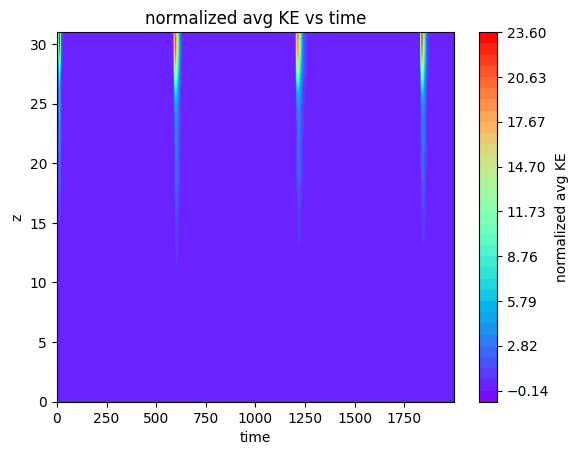

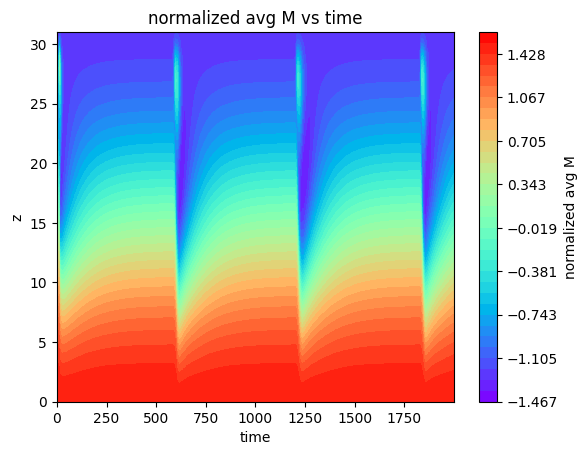

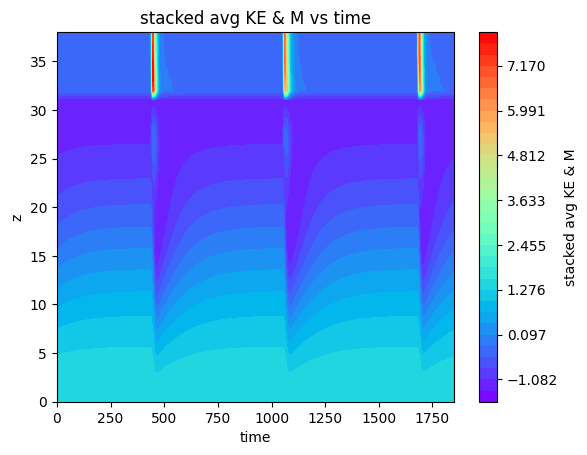

In [7]:
DH_times_24 = 7
ind = DH_times_24 + 4
avg_KE_all_time = get_all_data("avg KE by xy", Nz, all_filepaths[ind])
avg_M_all_time = get_all_data("avg M by xy", Nz, all_filepaths[ind])
avg_D_all_time = -get_all_data("avg -D by xy", Nz, all_filepaths[ind])

avg_KE_mean_byrow = np.mean(avg_KE_all_time, axis=1, keepdims = True)
avg_M_mean_byrow = np.mean(avg_M_all_time, axis=1, keepdims = True)
avg_KE_mean = np.mean(avg_KE_all_time)
avg_M_mean = np.mean(avg_M_all_time)


avg_KE_std_byrow = np.std(avg_KE_all_time, axis=1, keepdims = True)
avg_M_std_byrow = np.std(avg_M_all_time, axis=1, keepdims = True)
avg_KE_std = np.std(avg_KE_all_time)
avg_M_std = np.std(avg_M_all_time)


nmlzd_avg_KE_row = (avg_KE_all_time-avg_KE_mean_byrow)/avg_KE_std_byrow
nmlzd_avg_M_row = (avg_M_all_time-avg_M_mean_byrow)/avg_M_std_byrow
nmlzd_avg_KE = (avg_KE_all_time-avg_KE_mean)/avg_KE_std
nmlzd_avg_M = (avg_M_all_time-avg_M_mean)/avg_M_std

draw_contour(nmlzd_avg_KE, "normalized avg KE")
draw_contour(nmlzd_avg_M, "normalized avg M")

stacked_KEM = np.vstack((nmlzd_avg_M , nmlzd_avg_KE_row[25:,:]))
draw_contour(stacked_KEM[:,150:], "stacked avg KE & M")

### Tried several different start-time and end-time. [750, 1800] is a good one. Just not sure whether using initial value at time 1999 is fine.

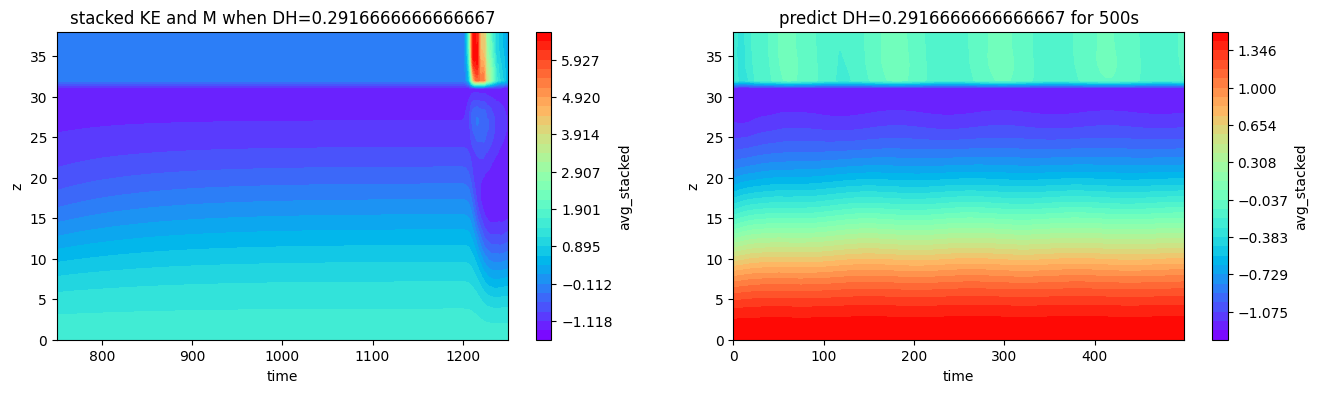

<Figure size 640x480 with 0 Axes>

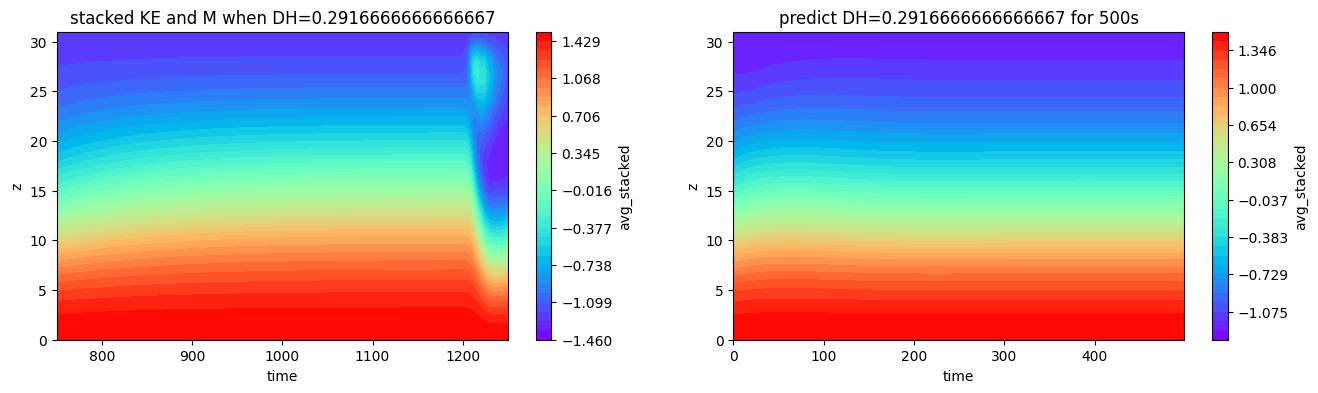

<Figure size 640x480 with 0 Axes>

In [8]:
#local_look(DH_times_24,"nipy_spectral",750, 1250, stacked_KEM, "stacked", 1999, 500)
#local_look(DH_times_24,"Spectral_r",750, 1250, stacked_KEM, "stacked", 1999, 500)
#local_look(DH_times_24,"viridis",750, 1250, stacked_KEM, "stacked", 1999, 500)
local_look(DH_times_24,"rainbow",750, 1250, stacked_KEM, "stacked", 1999, 500)
#draw_contour(stacked_KEM[:,1300:1800], "1300-1800 stacked avg KE & M")
#draw_contour(stacked_KEM[:,750:1250], "750-1250 stacked avg KE & M")
local_look(DH_times_24,"rainbow",750, 1250, nmlzd_avg_M, "stacked", 1999, 500)

In [18]:
def local_look_M(DH, co_map, begin_time, end_time, data_all, name, time, timesteps):
    datasample = data_all[:, begin_time:end_time]
    phi, Lam = DMD(datasample)
    b = pinv(phi) @ data_all[:,time]
    dt = 1
    future_data = compute_future_states(phi, Lam, b, timesteps, 1)
    n_rows, n_columns = datasample.shape
    x_ax = np.linspace(begin_time, end_time, n_columns)
    y_ax = np.linspace(0, n_rows-1, n_rows)
    X_ax, Y_ax = np.meshgrid(x_ax, y_ax)
    
    max_lev, min_lev = np.max(datasample), np.min(datasample)
    levels = np.arange(min_lev-(max_lev-min_lev)/32, max_lev+(max_lev-min_lev)/32, (max_lev-min_lev)/32)
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    #plt.contourf(X_ax, Y_ax, datasample, levels, cmap='Spectral_r')
    #plt.contourf(X_ax, Y_ax, datasample, levels, cmap='viridis')
    plt.contourf(X_ax, Y_ax, datasample, levels, cmap=f'{co_map}')
    plt.colorbar(label=f'avg_{name}')
    plt.xlabel('time')
    plt.ylabel('z')
    plt.title(f'{name} from t={begin_time} to t={end_time}, DH={DH/24}')
    #plt.savefig(f'{begin_time}to{end_time}.png', dpi=200,bbox_inches='tight')

    max_lev, min_lev = np.max(future_data), np.min(future_data)
    levels = np.arange(min_lev-(max_lev-min_lev)/32, max_lev+(max_lev-min_lev)/32, (max_lev-min_lev)/32)
    plt.subplot(1,2,2)
    #plt.contourf(future_data, levels, cmap='Spectral_r')
    #plt.contourf(future_data, levels, cmap='viridis')
    plt.contourf(future_data, levels, cmap=f'{co_map}')
    plt.colorbar(label=f'avg_{name}')
    plt.xlabel('time')
    plt.ylabel('z')
    plt.title(f'predict M for 500 unit time, DH={DH/24}')
    plt.savefig(f'{co_map}_{DH}_M.png', dpi=200,bbox_inches='tight')
    plt.show()
    plt.clf()

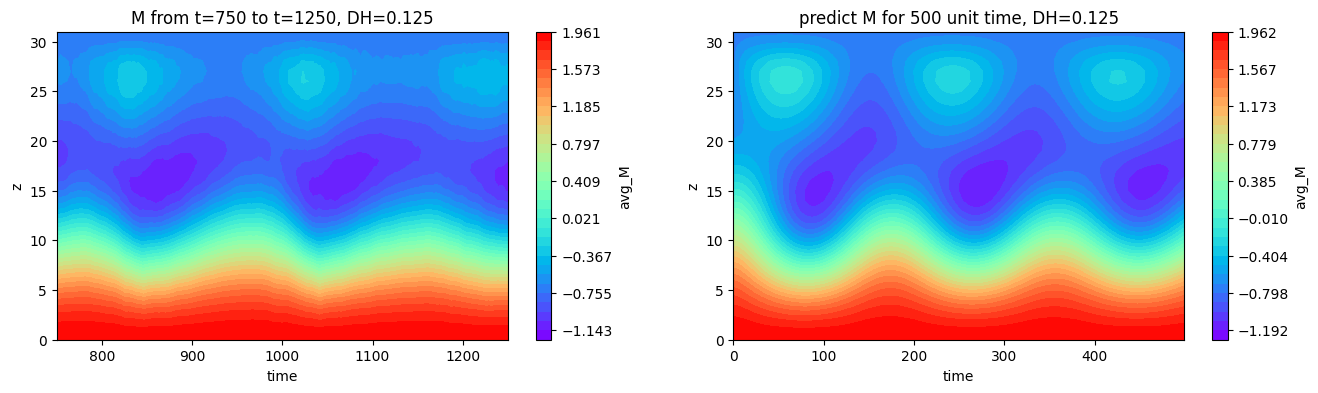

<Figure size 640x480 with 0 Axes>

In [21]:
DH_times_24 = 3
ind = DH_times_24 + 4
avg_KE_all_time = get_all_data("avg KE by xy", Nz, all_filepaths[ind])
avg_M_all_time = get_all_data("avg M by xy", Nz, all_filepaths[ind])
avg_D_all_time = -get_all_data("avg -D by xy", Nz, all_filepaths[ind])

avg_KE_mean_byrow = np.mean(avg_KE_all_time, axis=1, keepdims = True)
avg_M_mean_byrow = np.mean(avg_M_all_time, axis=1, keepdims = True)
avg_KE_mean = np.mean(avg_KE_all_time)
avg_M_mean = np.mean(avg_M_all_time)


avg_KE_std_byrow = np.std(avg_KE_all_time, axis=1, keepdims = True)
avg_M_std_byrow = np.std(avg_M_all_time, axis=1, keepdims = True)
avg_KE_std = np.std(avg_KE_all_time)
avg_M_std = np.std(avg_M_all_time)


nmlzd_avg_KE_row = (avg_KE_all_time-avg_KE_mean_byrow)/avg_KE_std_byrow
nmlzd_avg_M_row = (avg_M_all_time-avg_M_mean_byrow)/avg_M_std_byrow
nmlzd_avg_KE = (avg_KE_all_time-avg_KE_mean)/avg_KE_std
nmlzd_avg_M = (avg_M_all_time-avg_M_mean)/avg_M_std

stacked_KEM = np.vstack((nmlzd_avg_M , nmlzd_avg_KE_row[25:,:]))
local_look_M(DH_times_24,"rainbow",750, 1250, nmlzd_avg_M, "M", 1999, 500)

In [11]:
def eig_look(begin_time, end_time, data_all, name, DH):
    sample_data = data_all[:,begin_time:end_time]
    phi, Lam = DMD(sample_data)
    dummy = np.arange(0,2 *np.pi,0.01)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.scatter(np.real(Lam),np.imag(Lam))
    plt.plot(np.cos(dummy),np.sin(dummy))
    #plt.xlim(0.9,1.05)
    #plt.ylim(-0.1,0.1)
    plt.title(f'Eigenvalue of {name} {DH}/24 by z vs time')
    plt.grid(linestyle="dotted")
    plt.savefig("eig")
    #plt.show()

    plt.subplot(1,2,2)
    Lam_sort = Lam[np.argsort(-np.abs(Lam))]
    plt.plot(np.abs(Lam_sort))
    plt.grid(linestyle="dotted")
    plt.show()
    #plt.plot(np.abs(np.angle(Lam_sort)))
    #plt.show()
    #print(2* np.pi/np.abs(np.angle(Lam_sort[1])))

In [36]:
def eig_look(begin_time, end_time, data_all, name, DH):
    sample_data = data_all[:,begin_time:end_time]
    phi, Lam = DMD(sample_data)
    dummy = np.arange(0,2 *np.pi,0.01)
    plt.figure(figsize=(6,6))

    plt.scatter(np.real(Lam),np.imag(Lam))
    plt.plot(np.cos(dummy),np.sin(dummy))
    #plt.xlim(0.9,1.05)
    #plt.ylim(-0.1,0.1)
    plt.title(f'Eigenvalue of {name} {DH}/24 by z vs time')
    plt.grid(linestyle="dotted")
    plt.savefig("eig")
    plt.show()

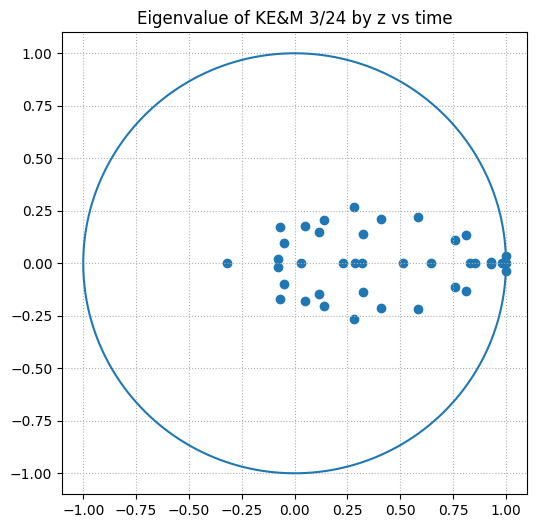

In [37]:
eig_look(750, 1250, stacked_KEM, "KE&M", DH_times_24)

In [11]:
"""
beg_os_t = 0
end_os_t = 0
avg_KE_loc_T=avg_KE_all_time[:, beg_os_t:end_os_t] # This is where we want to show from the sample data
avg_M_loc_T=avg_M_all_time[:, beg_os_t:end_os_t]
#avg_nD_loc_T=np.transpose(avg_nD_all_time[beg_os_t:end_os_t,:])

n_rows, n_columns = avg_KE_loc_T.shape
x_ax = np.linspace(beg_os_t, end_os_t, n_columns)
y_ax = np.linspace(0, n_rows-1, n_rows)
X_ax, Y_ax = np.meshgrid(x_ax, y_ax)

# KEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKE
plt.contourf(X_ax, Y_ax, avg_KE_loc_T, cmap='Spectral_r')
plt.colorbar(label='avg_KE')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg KE by z vs time')
# plt.savefig(f'avg_KE_local.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()

plt.contourf(future_KE, cmap='Spectral_r')
plt.colorbar(label='avg_KE')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg KE by z vs time')
# plt.savefig(f'predict_avg_KE_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()

# MMMMMMMMMMMMMMMMMMMMMMMMMMMMMM
plt.contourf(X_ax, Y_ax, avg_M_loc_T, cmap='Spectral_r')
plt.colorbar(label='avg_M')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg M by z vs time')
# plt.savefig(f'avg_KE_local.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()

plt.contourf(future_M, cmap='Spectral_r')
plt.colorbar(label='avg_M')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg M by z vs time')
# plt.savefig(f'predict_avg_KE_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()
"""
# DDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
"""
plt.contourf(X_ax, Y_ax, avg_nD_loc_T, cmap='Spectral_r')
plt.colorbar(label='avg_nD')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg nD by z vs time')
# plt.savefig(f'avg_KE_local.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()

plt.contourf(future_nD, cmap='Spectral_r')
plt.colorbar(label='avg_nD')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg nD by z vs time')
# plt.savefig(f'predict_avg_KE_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()"""

"\nplt.contourf(X_ax, Y_ax, avg_nD_loc_T, cmap='Spectral_r')\nplt.colorbar(label='avg_nD')\nplt.xlabel('time')\nplt.ylabel('z')\nplt.title('avg nD by z vs time')\n# plt.savefig(f'avg_KE_local.png', dpi=200,bbox_inches='tight')\nplt.show()\nmatplotlib.pyplot.close()\n\nplt.contourf(future_nD, cmap='Spectral_r')\nplt.colorbar(label='avg_nD')\nplt.xlabel('time')\nplt.ylabel('z')\nplt.title('avg nD by z vs time')\n# plt.savefig(f'predict_avg_KE_t.png', dpi=200,bbox_inches='tight')\nplt.show()\nmatplotlib.pyplot.close()"

In [12]:
#for beginning_time in range(600, 3000, 100):
#    local_look(beginning_time, 3500, avg_KE_all_time, 'KE')
# 1800 and 2800 are best two

In [13]:
#for beginning_time in range(600, 3000, 100):
#    local_look(beginning_time, 3500, avg_M_all_time, 'M')

In [14]:
# The following are saved for debugging purpose
"""
recorded = False
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        st = file['scales/sim_time']
        simtime = np.array(st)
        avg_KE_0 = file["tasks"]["avg KE by z"]
        avg_KE = np.reshape(avg_KE_0, (len(simtime),Nz))
        for t in range(len(simtime)):
            avg_KE_T=np.transpose(avg_KE[t,:])
            avg_KE_T = np.reshape(avg_KE_T, (1, Nz))
            if recorded == False:
                avg_KE_all_time = avg_KE_T
                recorded = True
            else:
                avg_KE_all_time = np.concatenate((avg_KE_all_time, avg_KE_T))
print(np.shape(avg_KE_all_time))
print(np.shape(np.transpose(avg_KE_all_time[:,:])))
avg_KE_allt_T=np.transpose(avg_KE_all_time[:,:])
plt.contourf(avg_KE_allt_T, cmap='Spectral_r')
plt.colorbar(label='avg_KE')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg KE by z vs time')
plt.savefig(f'avg_KE_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()"""
"""
recorded = False
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        avg_M_0 = file["tasks"]["avg M by z"]
        avg_M = np.reshape(avg_M_0, (len(simtime), Nz)) # which is (1000, 32)
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(len(simtime)):
            avg_M_T=np.transpose(avg_M[t,:])
            avg_M_T = np.reshape(avg_M_T, (1, Nz))
            if recorded == False:
                avg_M_all_time = avg_M_T
                recorded = True
            else:
                avg_M_all_time = np.concatenate((avg_M_all_time, avg_M_T))
print(np.shape(avg_M_all_time))
print(np.shape(np.transpose(avg_M_all_time[:,:])))
avg_M_allt_T=np.transpose(avg_M_all_time[:,:])
plt.contourf(avg_M_allt_T, cmap='Spectral_r')
plt.colorbar(label='avg_M')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg_M_by_z_vs_time')
plt.savefig(f'avg_M_t.png', dpi=200,bbox_inches='tight')
plt.show()

matplotlib.pyplot.close()
"""
"""recorded = False
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        avg_nD_0 = file["tasks"]["avg -D by z"]
        avg_nD = np.reshape(avg_nD_0, (len(simtime), Nz)) # which is (1000, 32)
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(len(simtime)):
            avg_nD_T=np.transpose(avg_nD[t,:])
            avg_nD_T = np.reshape(avg_nD_T, (1, Nz))
            if recorded == False:
                avg_nD_all_time = avg_nD_T
                recorded = True
            else:
                avg_nD_all_time = np.concatenate((avg_nD_all_time, avg_nD_T))
print(np.shape(avg_nD_all_time))
print(np.shape(np.transpose(avg_nD_all_time[:,:])))
avg_nD_allt_T=np.transpose(avg_nD_all_time[:,:])
plt.contourf(avg_nD_allt_T, cmap='Spectral_r')
plt.colorbar(label='avg_nD')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg -D by z vs time')
plt.savefig(f'avg_nD_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()"""

'recorded = False\nfor file in file_paths:\n    with h5py.File(file, mode=\'r\') as file:\n        avg_nD_0 = file["tasks"]["avg -D by z"]\n        avg_nD = np.reshape(avg_nD_0, (len(simtime), Nz)) # which is (1000, 32)\n        st = file[\'scales/sim_time\']\n        simtime = np.array(st)\n        for t in range(len(simtime)):\n            avg_nD_T=np.transpose(avg_nD[t,:])\n            avg_nD_T = np.reshape(avg_nD_T, (1, Nz))\n            if recorded == False:\n                avg_nD_all_time = avg_nD_T\n                recorded = True\n            else:\n                avg_nD_all_time = np.concatenate((avg_nD_all_time, avg_nD_T))\nprint(np.shape(avg_nD_all_time))\nprint(np.shape(np.transpose(avg_nD_all_time[:,:])))\navg_nD_allt_T=np.transpose(avg_nD_all_time[:,:])\nplt.contourf(avg_nD_allt_T, cmap=\'Spectral_r\')\nplt.colorbar(label=\'avg_nD\')\nplt.xlabel(\'time\')\nplt.ylabel(\'z\')\nplt.title(\'avg -D by z vs time\')\nplt.savefig(f\'avg_nD_t.png\', dpi=200,bbox_inches=\'tight\'

In [15]:
x1 = np.arange(9.0).reshape((3, 3))
print(x1)
print(np.mean(x1, axis=1, keepdims = True))

[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[1.]
 [4.]
 [7.]]
